Ομάδα

1.   Ιωάννα Βασιλικού 1115202100012
2.   Άγγελος Τσιτσόλη 1115202000200



In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import colors
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import folium
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import json
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
from nltk import BigramCollocationFinder
from nltk.collocations import BigramAssocMeasures
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Ερώτημα 1ο: Ανάλυση Δεδομένων (Data exploration)


In [114]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def remove_punctuation(input_string):
   # Make a translator object that will replace all punctuation with a space
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))

    # Use the translator object to remove punctuation from the input string
    no_punct = input_string.translate(translator)
    return no_punct

def remove_stopwords(input_string):
    if not isinstance(input_string, str):
        input_string = ' '.join(input_string)
    tokens = input_string.split()
    no_stop = [word for word in tokens if not word in stop_words]
    return ' '.join(no_stop)

def lemmatize_words(input_string):
    tokens = input_string.split()
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized)


def text_cleaning(df):

    for col in ['transit', 'description', 'name']:
        # # Decapitalize the text
        df[col] = df[col].str.lower()

    for col in ['transit', 'description', 'amenities', 'name']:
        # replace "Wi-Fi" and "WI-FI" with "WIFI" and "WiFi"
        df[col] = df[col].apply(lambda x: x.replace("Wi-Fi", "WiFi").replace("WI-FI", "WIFI").replace("wi-fi", "wifi").replace("Wi-fi", "Wifi").replace("wi-Fi", "Wifi"))
        # # Decapitalize the text
        # df[col] = df[col].str.lower()
        #remove punctuation
        df[col] = df[col].apply(remove_punctuation)
        #remove non ascii characters
        df[col] = df[col].apply(lambda x: x.encode("ascii", "ignore").decode())
        #tokenization
        df[col] = df[col].apply(lambda x: x.split())
        #remove stopwords
        df[col] = df[col].apply(remove_stopwords)
        #lemmatization
        df[col] = df[col].apply(lemmatize_words)


    # drop rows where any of the specified columns contain 'translation missing en hosting amenity 49' or 'translation missing en hosting amenity 50'
    df = df[~df.apply(lambda row: 'translation missing en hosting amenity 49' in ' '.join(row.values.astype(str)) or 'translation missing en hosting amenity 50'in ' '.join(row.values.astype(str)) or 'translation missing en hosting amenity 49 translation missing en hosting amenity 50' in ' '.join(row.values.astype(str)), axis=1)]

    # drop rows where 'description' column doesn't contain any letter
    df = df[df['description'].str.contains(r'[a-zA-Z]', na=False)]
    df = df[df['transit'].str.contains(r'[a-zA-Z]', na=False)]
    df = df[df['amenities'].str.contains(r'[a-zA-Z]', na=False)]
    df = df[df['name'].str.contains(r'[a-zA-Z]', na=False)]

    if 'description_name' in df.columns:
      # replace "Wi-Fi" and "WI-FI" with "WIFI" and "WiFi"
        df[col] = df[col].apply(lambda x: x.replace("Wi-Fi", "WiFi").replace("WI-FI", "WIFI").replace("wi-fi", "wifi").replace("Wi-fi", "Wifi").replace("wi-Fi", "Wifi"))
        #remove punctuation
        df[col] = df[col].apply(remove_punctuation)
        #remove non ascii characters
        df[col] = df[col].apply(lambda x: x.encode("ascii", "ignore").decode())
        #tokenization
        df[col] = df[col].apply(lambda x: x.split())
        #remove stopwords
        df[col] = df[col].apply(remove_stopwords)
        #lemmatization
        df[col] = df[col].apply(lemmatize_words)
        # drop rows where 'description' column doesn't contain any letter
        df = df[df['description_name'].str.contains(r'[a-zA-Z]', na=False)]




    # Replace empty strings with NaN in the 'description' column
    for column in df.columns:
        df[column] = df[column].replace('', np.nan)

    # Drop rows with NaN in 'description' column
    df = df.dropna()

    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [115]:
def strip_everything(df):

    for col in df.columns:

        # replace $ symbol in price
        if col == 'price':
          df[col] = df[col].str.replace('$', '')

        # replace % symbol in hostr response rate
        if col == 'host_response_rate':
          df[col] = df[col].str.replace('%', '')

        # remove values outside of the range [1, 100]
        if col in ['review_scores_rating', 'host_response_rate']:
          df[col] = pd.to_numeric(df[col], errors='coerce')  # convert to numeric
          df.loc[(df[col] > 100) | (df[col] < 1), col] = np.nan
          df[col] = df[col].astype(float).astype(pd.Int64Dtype())

        # make the zipcode and longtitude a number without spaces
        if col in ['zipcode', 'longtitude']:
          df[col] = df[col].str.replace(' ', '')

        # make the zipcode a number without dots, remove non-numeric characters and keep only the first 5 numbers
        if col in ['zipcode']:
          df[col] = df[col].str.replace('.', '')
          df[col] = df[col].str.replace('\D', '', regex=True)
          df[col] = df[col].str.slice(start=0, stop=5)

        # keep only the integer from the number of bedrooms, beds, bathrooms and review score rating
        if col in ['bedrooms', 'beds', 'review_scores_rating', 'bathrooms', 'price']:
            df[col] = df[col].astype(str).str.split('.').str[0]

        # remove values outside the range [0, 20]
        if col in ['bedrooms', 'beds', 'bathrooms', 'accommodates']:
          df[col] = pd.to_numeric(df[col], errors='coerce')  # convert to numeric
          df.loc[(df[col] > 20) | (df[col] < 0), col] = np.nan
          df[col] = df[col].astype(float).astype(pd.Int64Dtype())

        # check the values to be "t" or "f"
        if col in ['host_has_profile_pick', 'host_identity_verified', 'instant_bookable']:
          df.loc[~df[col].isin(['t', 'f']), col] = np.nan

        # delete the rows without availability
        if col == 'availability_365':
          df.loc[df[col] == 0, col] = np.nan
          df[col] = df[col].astype(float).astype(pd.Int64Dtype())


    #first_review
    df['first_review'] = df['first_review'].replace('""', pd.NA, regex=False)
    df = df.dropna(subset=['first_review'])

    #amenities
    df = df[df['amenities'] != '{}']

    #minimum_nights
    #Keep rows where 'minimum_nights' is less than or equal to 30 and greater than 0
    df = df.loc[(df['minimum_nights'] <= 30) & (df['minimum_nights'] > 0)]


    #zipcode
    df['zipcode'] = df['zipcode'].replace('""', pd.NA, regex=False)


    #transit
    df['transit'] = df['transit'].replace('""', pd.NA, regex=False)


    #review_scores_rating
    df['review_scores_rating'] = df['review_scores_rating'].replace('""', pd.NA, regex=False)


    #neighbourhood
    df['neighbourhood'] = df['neighbourhood'].replace('""', pd.NA, regex=False)


    #price
    # Convert 'price' column to numeric, non-numeric values are converted to NaN
    df['price'] = pd.to_numeric(df['price'], errors='coerce')


    #last_review
    df['last_review'] = df['last_review'].replace('""', pd.NA, regex=False)


    #host_response_rate
    df['host_response_rate'] = df['host_response_rate'].replace('""', pd.NA, regex=False)


    return df

In [116]:
# give the file paths
listings_path_febrouary = '/content/drive/MyDrive/ΤΕΔΕ/2019/febrouary/listings.csv'
listings_path_march = '/content/drive/MyDrive/ΤΕΔΕ/2019/march/listings.csv'
listings_path_april = '/content/drive/MyDrive/ΤΕΔΕ/2019/april/listings.csv'

listings0_path_febrouary = '/content/drive/MyDrive/ΤΕΔΕ/2019/febrouary/listings0.csv'
listings0_path_march = '/content/drive/MyDrive/ΤΕΔΕ/2019/march/listings0.csv'
listings0_path_april = '/content/drive/MyDrive/ΤΕΔΕ/2019/april/listings0.csv'

neighbourhoods_path_febrouary = '/content/drive/MyDrive/ΤΕΔΕ/2019/febrouary/neighbourhoods.csv'
neighbourhoods_path_march = '/content/drive/MyDrive/ΤΕΔΕ/2019/march/neighbourhoods.csv'
neighbourhoods_path_april = '/content/drive/MyDrive/ΤΕΔΕ/2019/april/neighbourhoods.csv'

# select the columns that we want to use for the results
columns_to_select = ['id', 'zipcode', 'transit', 'bedrooms', 'beds',
                     'review_scores_rating', 'number_of_reviews',
                     'neighbourhood', 'name', 'latitude', 'longitude',
                     'last_review', 'instant_bookable', 'host_since',
                     'host_response_rate',
                     'host_identity_verified', 'host_has_profile_pic',
                     'first_review', 'description', 'city', 'cancellation_policy', 'bed_type', 'bathrooms',
                     'accommodates', 'amenities', 'room_type',
                     'property_type', 'price', 'availability_365', 'minimum_nights']

# read a data frame from every file
listings_df_febrouary = pd.read_csv(listings_path_febrouary, usecols=columns_to_select)
listings_df_march = pd.read_csv(listings_path_march, usecols=columns_to_select)
listings_df_april = pd.read_csv(listings_path_april, usecols=columns_to_select)

listings0_df_febrouary = pd.read_csv(listings0_path_febrouary)
listings0_df_march = pd.read_csv(listings0_path_march)
listings0_df_april = pd.read_csv(listings0_path_april)

neighbourhoods_df_febrouary = pd.read_csv(neighbourhoods_path_febrouary)
neighbourhoods_df_march = pd.read_csv(neighbourhoods_path_march)
neighbourhoods_df_april = pd.read_csv(neighbourhoods_path_april)

# create a new column 'month' with the corresponding month name for each DataFrame
listings_df_febrouary['month'] = 'february'
listings_df_march['month'] = 'march'
listings_df_april['month'] = 'april'

# merge the data from the three months
listings_df = pd.concat( [listings_df_febrouary, listings_df_march, listings_df_april] , ignore_index=True )
listings0_df = pd.concat( [listings0_df_febrouary, listings0_df_march, listings0_df_april] , ignore_index=True )
neighbourhoods_df = pd.concat( [neighbourhoods_df_febrouary, neighbourhoods_df_march, neighbourhoods_df_april] , ignore_index=True )

# extract unique neighbourhood names
unique_neighbourhoods = neighbourhoods_df['neighbourhood'].unique()

# filter listings0_df to keep only the rows with neighbourhoods in unique_neighbourhoods
listings0_df_filtered = listings0_df[listings0_df['neighbourhood'].isin(unique_neighbourhoods)]

# update the 'neighbourhood' column of listings_df with listings0_df_filtered
listings_df['neighbourhood'] = listings0_df_filtered['neighbourhood']

# filter listings_df based on listings0_df_filtered
df = listings_df[listings_df['id'].isin(listings0_df_filtered['id'])]

# drop duplicates based on 'id' and 'month'
df_duplicates = df[df.duplicated(subset=['id', 'month'], keep=False)]

# drop duplicates based on 'id' and 'month'
df = df.drop_duplicates(subset=['id', 'month'])

# drop the rows with no value in a column
df = df.dropna()

# call the function
df = strip_everything(df)

# drop the rows with no value in a column
df = df.dropna()

# text cleaning
df = text_cleaning(df)

# clean 'amenities' column
# List of words to replace and their replacements
words_to_replace = [
    (["Internet", "Wifi", "Heating", "Ethernet connection", "Pocket wifi", "EV charger", "Netflix", "HBO GO", "Cable"], 'Electricity_Technology'),
    (["Hangers", "Bed linen", "Extra pillow blanket", "Room darkening shade",
      "Indoor fireplace", "Private living room", "Fire pit", "Bedroom comfort",
      "Firm mattress", "Memory foam mattress", "Murphy bed", "Pillow top mattress",
      "Mudroom", "Day bed", "Standing valet", "Ironing Board"], 'Indoor'),
    (["Cable TV", "Smart TV", "TV", "Air conditioning", "Elevator",
      "Buzzer wireless intercom", "Washer Dryer", "Hair dryer", "Iron",
      "Washer", "Dryer", "Game console", "DVD player", "Keypad",
      "Sound system", "High resolution computer monitor", "Printer",
      "Fax machine", "Central air conditioning", "Ceiling fan",
      "Projector screen", "Amazon Echo", "Warming drawer", "Heat lamp"], 'Electronic_Devices'),
    (["Safety card", "Self check", "Fire extinguisher", "24 hour check", "Smoke detector", "Carbon monoxide detector",
      "Lock bedroom door", "Self check Lockbox", "Private entrance", "Window guard", "Doorman",
      "Fireplace guard", "Smart lock", "Lockbox"], 'Security'),
    (["Luggage dropoff allowed", "Cleaning checkout", "Smoking allowed", "Building staff",
      "Suitable event", "Well lit path entrance", "Formal dining area", "Exercise equipment",
      "Heated floor", "Laptop friendly workspace"], 'Services'),
    (["Stand alone steam shower", "Bidet", "Heated towel rack", "En suite bathroom", "Soaking tub",
      "Roll shower", "Toilet paper", "Toilet", "Rain shower", "Bathroom essential", "Bathtub", "Walk shower", "Body soap",
      "Bath towel", "Hot water", "First aid kit", "Shampoo", "Essentials",
      "Touchless faucet"], 'Bathroom'),
    (["Family kid friendly", "Patio balcony", "Host greets", "Long term stay allowed", "Childrens book toy",
      "Crib", "Pack n Play travel crib", "Childrens dinnerware", "Changing table", "Outlet cover",
      "Baby bath", "Babysitter recommendation", "Baby monitor", "Table corner guard", "High chair",
      "Stair gate", "Dog", "Cat", "Pets live property", "Pets allowed", "Pet", "pet"], 'Family'),
    (["Electric profiling bed", "Ground floor access", "Disabled parking spot",
      "Fixed grab bar", "Wide clearance shower toilet", "Wide clearance shower", "Accessible height toilet",
      "Wide clearance toilet", "Fixed grab bar shower", "Wide entryway",
      "Wheelchair accessible", "Flat path front door", "Wide hallway clearance", "Accessible height bed",
      "Handheld shower head", "Wide doorway", "Step free access", "Wide clearance bed", "Single level home", "Shower chair", "Bath chair", "bath chair", "shower", "toilet"], 'Accessibility'),
    (["Microwave",
      "Coffee maker","Refrigerator","Dishwasher","Oven","Stove","Kitchen","Full kitchen","Convection oven",
      "Kettle", "kettle", "Mini fridge","Espresso machine","Double oven","Wine cooler","Steam oven","Gas oven",
      "Freezer","Kitchenette","Dishes silverware","Cooking basic","Breakfast","BBQ grill",
      "Table", "table"],'Kitchen'),
    (["Lake access", "Hammock", "Private pool", "Sauna", "Alfresco bathtub",
      "Shared gym", "Sun lounger", "Jetted tub", "Beach view", "Private hot tub",
      "Beachfront", "Waterfront", "Outdoor parking", "Pool", "Ski", "Mountain view",
      "Terrace", "Gym", "Balcony", "Outdoor seating", "Terrace Balcony", "Hot tub",
      "Beach essential", "Free parking premise", "Free street parking", "Paid parking premise",
      "Garden backyard"], 'Outdoor'),
    (["translation missing en hosting amenity 50", "translation missing en hosting amenity 49"], 'Error'),
    (["Other"], '')
]

# Replace the words in the 'amenities' column
for words, replacement in words_to_replace:
    for word in words:
        df['amenities'] = df['amenities'].str.replace(word, replacement, regex=False)

# create the output file
df.to_csv('output.csv', index=False)

In [88]:
#Combining and cleaning the reviews file for question 1.10

# give the file paths
reviews_path_febrouary = '/content/drive/MyDrive/ΤΕΔΕ/2019/febrouary/reviews.csv'
reviews_path_march = '/content/drive/MyDrive/ΤΕΔΕ/2019/march/reviews.csv'
reviews_path_april = '/content/drive/MyDrive/ΤΕΔΕ/2019/april/reviews.csv'

# select the columns that we want to use for the results
columns_to_select = ['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments' ]

# Read the CSV files into dataframes
df_reviews_febrouary = pd.read_csv(reviews_path_febrouary, usecols=columns_to_select)
df_reviews_march = pd.read_csv(reviews_path_march, usecols=columns_to_select)
df_reviews_april = pd.read_csv(reviews_path_april, usecols=columns_to_select)

# Merge the data from the three months
df_reviews = pd.concat([df_reviews_febrouary, df_reviews_march, df_reviews_april], ignore_index=True)

# Convert all values in 'comments' column to string
df_reviews['comments'] = df_reviews['comments'].astype(str)

df_reviews['comments'] = df_reviews['comments'].replace(r'[^\w\s,]', ' ', regex=True)
#remove punctuation
df_reviews['comments'] = df_reviews['comments'].apply(remove_punctuation)
# Convert all values in 'comments' column to string and remove non-ASCII characters
df_reviews['comments'] = df_reviews['comments'].astype(str).apply(lambda x: x.encode("ascii", "ignore").decode())
#tokenization
df_reviews['comments'] = df_reviews['comments'].apply(lambda x: x.split())
#remove stopwords
df_reviews['comments'] = df_reviews['comments'].apply(remove_stopwords)
#lemmatization
df_reviews['comments'] = df_reviews['comments'].apply(lemmatize_words)

#drop non words
df_reviews = df_reviews[df_reviews['comments'].str.contains(r'[a-zA-Z]', na=False)]

# Drop rows where 'listing_id' column doesn't contain a number made from the digits 1-9
df_reviews = df_reviews[df_reviews['listing_id'].astype(str).str.contains(r'^[1-9]+$', na=False)]


# Drop rows where 'comments' column is empty or contains only whitespace
df_reviews = df_reviews[df_reviews['comments'].str.strip().astype(bool)]

# create the output file
df_reviews.to_csv('reviews_output.csv', index=False)

Ερώτημα 1.1

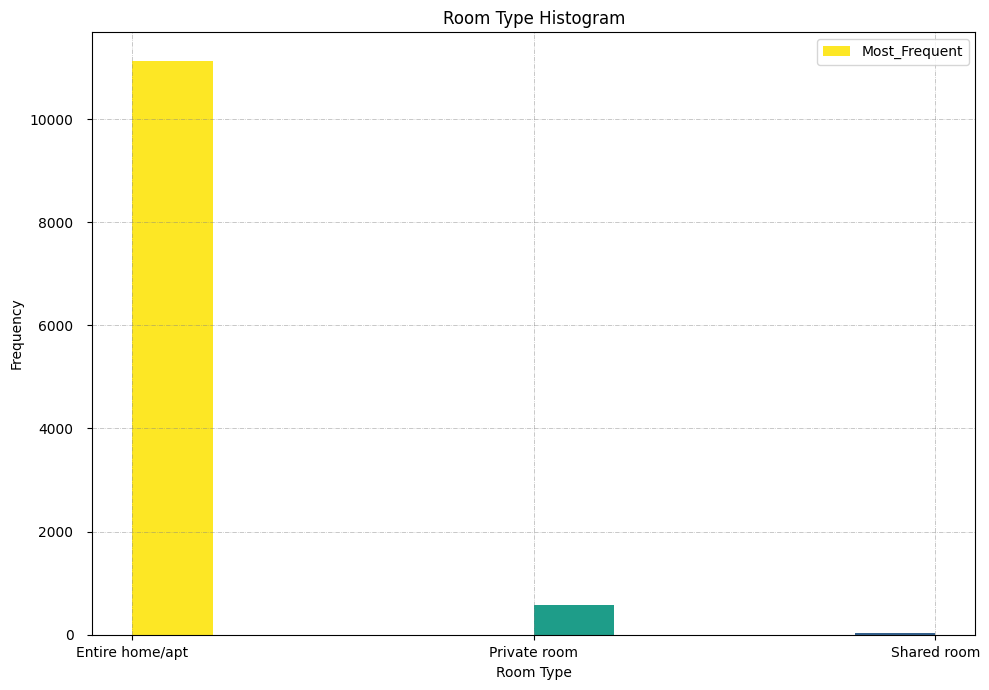

In [92]:
# ####################################################################### #
# Question 1.1

# load the data from the CSV file
df = pd.read_csv('output.csv')

# use the data frpm the 'room_types' column
x = df['room_type']

legend = ['Most_Frequent']

# create histogram
fig, axs = plt.subplots(1, 1, figsize =(10, 7), tight_layout = True)

# αdd padding between axes and labels
axs.xaxis.set_tick_params(pad = 5)
axs.yaxis.set_tick_params(pad = 10)

# add x and y gridlines
axs.grid(True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.6)

# create histogram
N, bins, patches = axs.hist(x, bins = 10)

# set colors
fracs = ((N**(1 / 5)) / N.max())
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

# format the plot
plt.xlabel("Room Type")
plt.ylabel("Frequency")
plt.legend(legend)
plt.title('Room Type Histogram')

# save the plot to a file
plt.savefig('question_1_1.png')

# ####################################################################### #

Ερώτημα 1.2

<ipython-input-86-21c6d79dab1e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].str.replace('%', '')
<ipython-input-86-21c6d79dab1e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')  # convert to numeric
<ipython-input-86-21c6d79dab1e>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

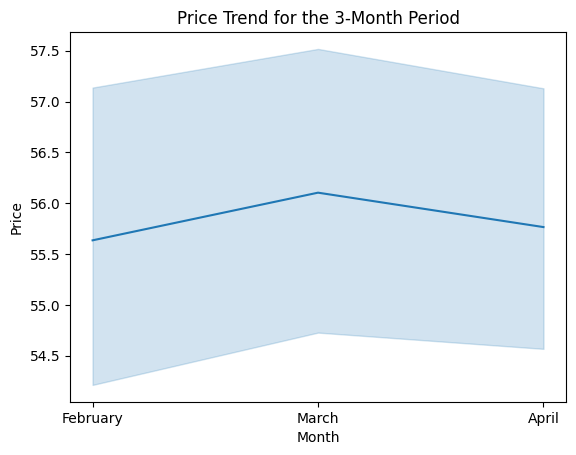

In [93]:
# ####################################################################### #
# Question 1.2

df_f = listings_df_febrouary
df_a = listings_df_april
df_m = listings_df_march

# drop the duplicate rows
df_f = df_f.drop_duplicates()
df_a = df_a.drop_duplicates()
df_m = df_m.drop_duplicates()

# drop the rows with no value in a column
df_f = df_f.dropna()
df_a = df_a.dropna()
df_m = df_m.dropna()

# call the function
df_f = strip_everything(df_f)
df_a = strip_everything(df_a)
df_m = strip_everything(df_m)

# drop the rows with no value in a column
df_f = df_f.dropna()
df_a = df_a.dropna()
df_m = df_m.dropna()

# Calculate the mean
mean_price_f = df_f['price'].mean()
mean_price_a = df_a['price'].mean()
mean_price_m = df_m['price'].mean()


april_price = df_a['price']
february_price = df_f['price']
march_price = df_m['price']

plt.figure()
# Create a new DataFrame with the price data for each month
df_months = pd.DataFrame({
    'February': february_price,
    'March': march_price,
    'April': april_price
})

# Melt the DataFrame to a long format which is suitable for seaborn
df_months = df_months.melt(var_name='Month', value_name='Price')

# Use seaborn's lineplot function to create the graph
sns.lineplot(data=df_months, x='Month', y='Price')

# Set the labels and title for the graph
plt.xlabel('Month')
plt.ylabel('Price')
plt.title('Price Trend for the 3-Month Period')

# Save the plot to a file
plt.savefig('question_1_2.png')

# ####################################################################### #

Ερώτημα 1.3

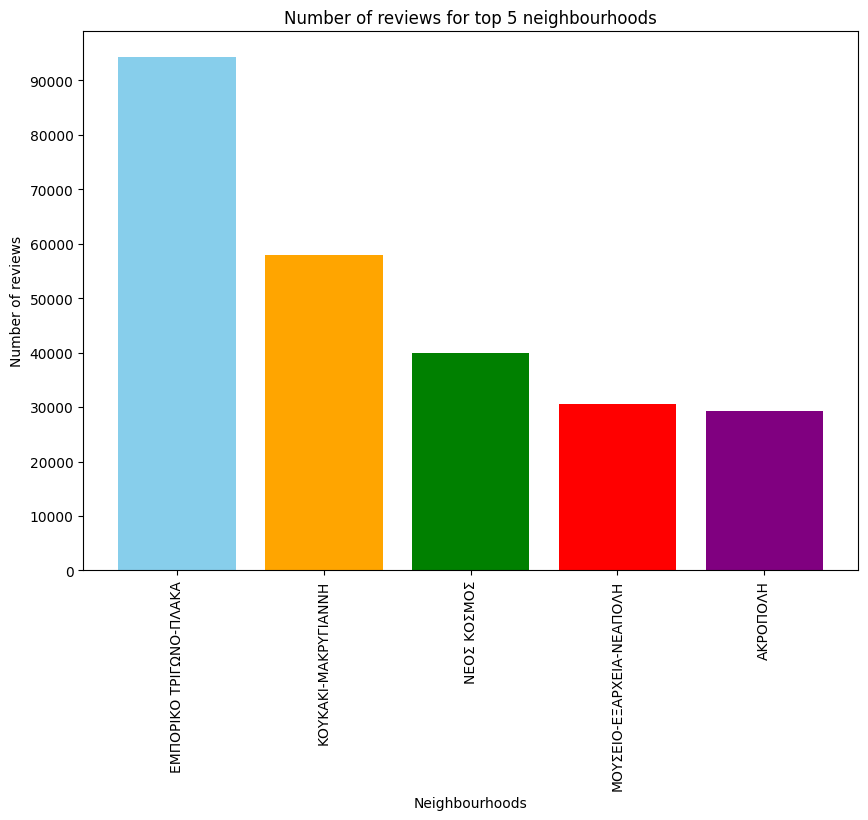

In [94]:
# ####################################################################### #
# Question 1.3

# Load the data from the CSV file
df = pd.read_csv('output.csv')

# Get the top five neighbourhoods with the most reviews
top_five_neighbourhoods = df.groupby('neighbourhood')['number_of_reviews'].sum().nlargest(5)

# Create a list of colors
colors = ['skyblue', 'orange', 'green', 'red', 'purple']

# Create bar plot with colors
plt.figure(figsize=(10, 7))
plt.bar(top_five_neighbourhoods.index, top_five_neighbourhoods.values, color=colors)

# Format the plot
plt.xlabel("Neighbourhoods")
plt.ylabel("Number of reviews")
plt.title('Number of reviews for top 5 neighbourhoods')
plt.xticks(rotation=90)

# Adjust y-axis to show numbers per 5000
max_y = top_five_neighbourhoods.max()
plt.yticks(np.arange(0, max_y+1, 10000))

# Save the plot to a file
plt.savefig('question_1_3.png')

# ####################################################################### #

Ερώτημα 1.4

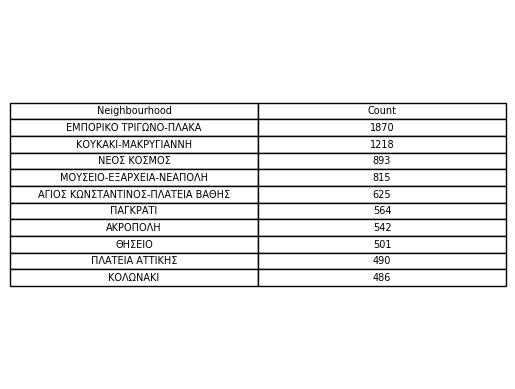

In [95]:
# ####################################################################### #
# Question 1.4

# Read the csv file
df_unique = pd.read_csv('output.csv')

# Count the occurrences of each neighbourhood
neighbourhood_counts = df_unique['neighbourhood'].value_counts()

# Create a DataFrame from the neighbourhood_counts Series
df_table = pd.DataFrame({'Neighbourhood': neighbourhood_counts.index, 'Count': neighbourhood_counts.values})

# Sort the counts in descending order
sorted_neighbourhoods = df_table.sort_values(by='Count', ascending=False)

# Select the first 10 neighbourhoods
top_neighbourhoods = sorted_neighbourhoods.head(10)

# Get data
neighbourhoods = top_neighbourhoods['Neighbourhood'].tolist()
counts = top_neighbourhoods['Count'].tolist()

# Create figure
fig, ax = plt.subplots(1, 1)

# Hide axes
ax.axis('tight')
ax.axis('off')

# Create table and display it
table_data = list(zip(neighbourhoods, counts))
ax.table(cellText=table_data, colLabels=['Neighbourhood', 'Count'], cellLoc = 'center', loc='center')

# Save the plot to a file
plt.savefig('question_1_4_table.png')

# ####################################################################### #

Ερώτημα 1.5

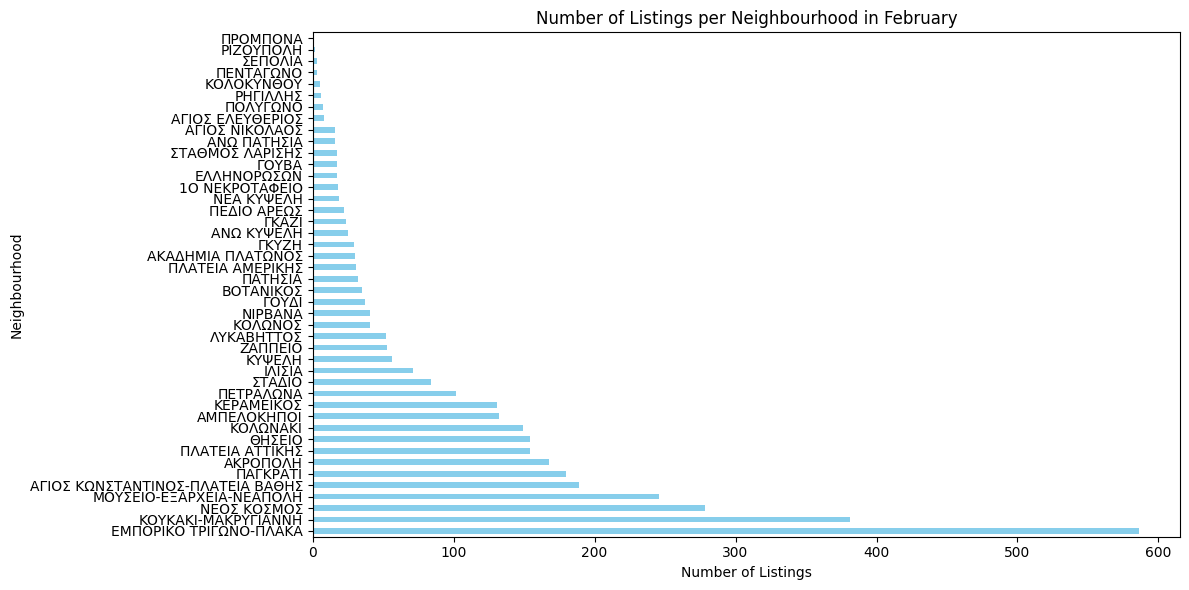

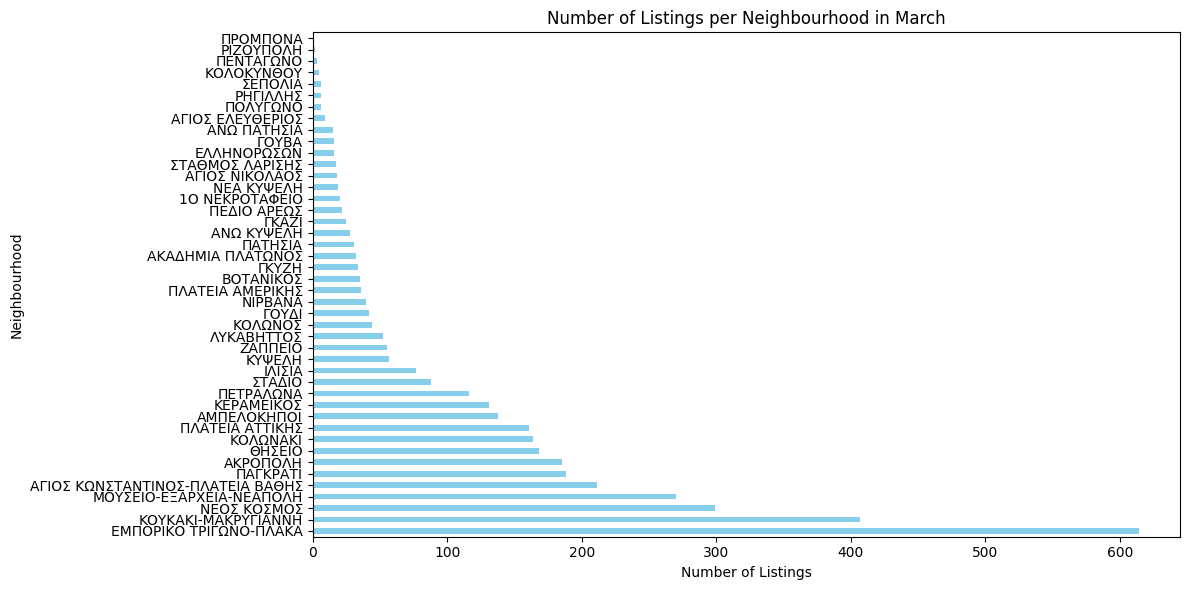

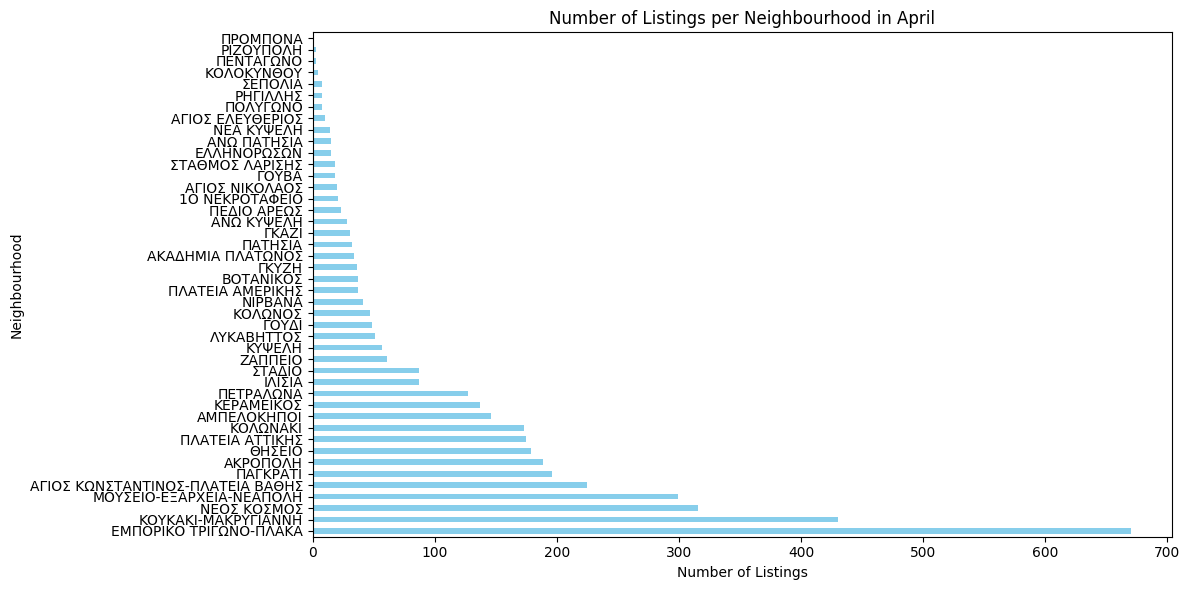

In [96]:
# ####################################################################### #
# Question 1.5

# Load the data from the CSV file
df = pd.read_csv('output.csv')

# Drop duplicate rows based on the 'id' column
df_unique = df.drop_duplicates(subset='id')

# Group by 'month' and 'neighbourhood' and count occurrences
neighbourhood_counts = df.groupby(['month', 'neighbourhood']).size().unstack(fill_value=0)

# Plot histograms for each month
months = ['february', 'march', 'april']

for month in months:
    plt.figure(figsize=(12, 6))

    # Sort neighbourhoods by count in descending order
    sorted_neighbourhoods = neighbourhood_counts.loc[month].sort_values(ascending=False)

    # Plot histogram
    sorted_neighbourhoods.plot(kind='barh', color='skyblue')  # 'barh' for horizontal bars

    # Add title and labels
    plt.title(f'Number of Listings per Neighbourhood in {month.capitalize()}')
    plt.xlabel('Number of Listings')
    plt.ylabel('Neighbourhood')

    plt.tight_layout()

    # Save the plot to a file
    plt.savefig('question_1_5.png')

# ####################################################################### #

Ερώτημα 1.6

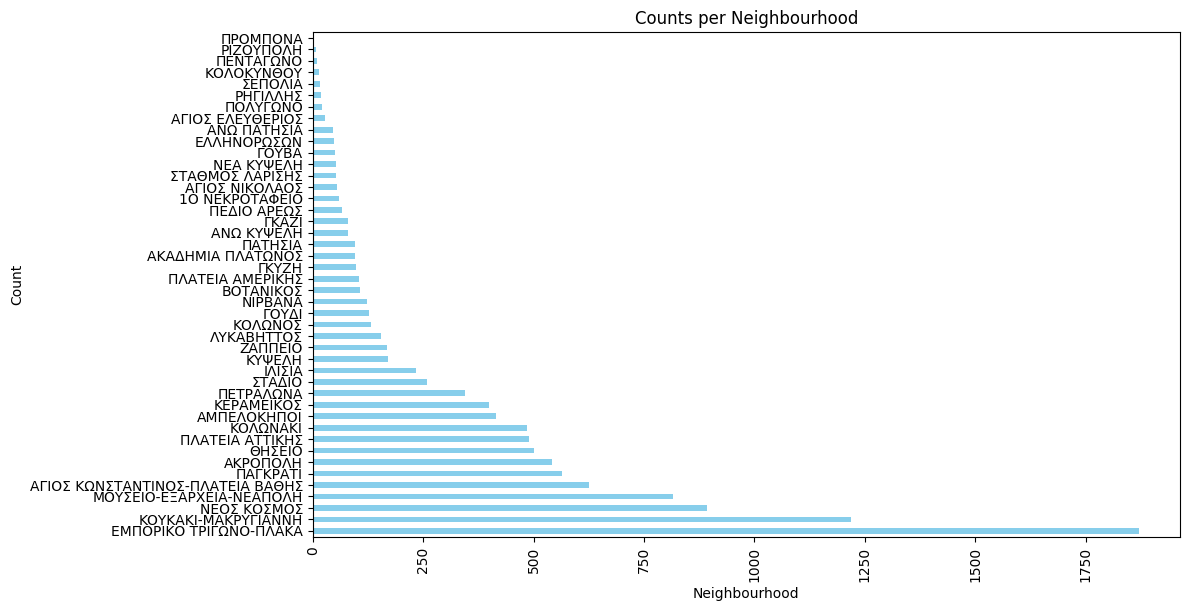

In [97]:
# ####################################################################### #
# Question 1.6

# Drop duplicate rows based on the 'id' column
df_unique = pd.read_csv('output.csv')

# Count the occurrences of each neighbourhood
neighbourhood_counts = df_unique['neighbourhood'].value_counts()

plt.figure(figsize=(12, 6))

# Sort neighbourhoods by count in descending order
sorted_neighbourhoods = neighbourhood_counts.sort_values(ascending=False)

# Plot histogram
sorted_neighbourhoods.plot(kind='barh', color='skyblue')  # 'barh' for horizontal bars

# Add title and labels
plt.xlabel('Neighbourhood')
plt.ylabel('Count')
plt.title('Counts per Neighbourhood')

plt.tight_layout()

# Rotate x-axis labels for better visibility if they are long
plt.xticks(rotation=90)

# Save the plot to a file
plt.savefig('question_1_6.png')

# ####################################################################### #

Ερώτημα 1.7

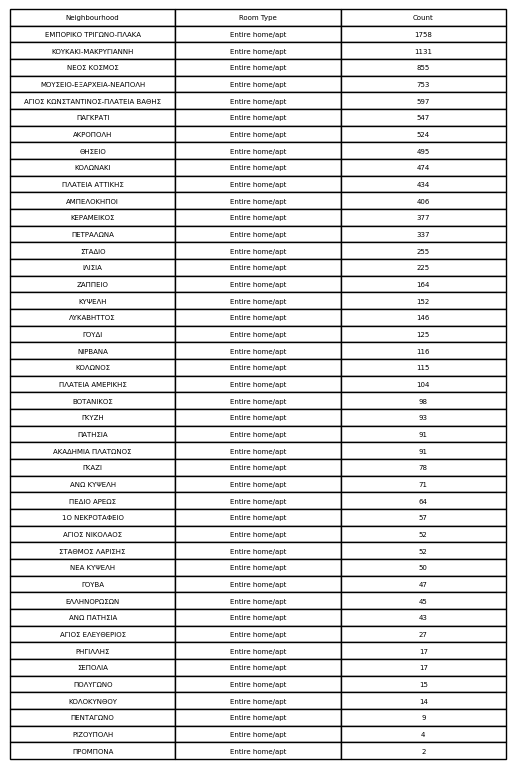

In [98]:
# ####################################################################### #
# Question 1.7

# Load the data from the CSV file
df = pd.read_csv('output.csv')

# Group by 'neighbourhood' and 'room_type' and count occurrences
neighbourhood_room_type_counts = df.groupby(['neighbourhood', 'room_type']).size().reset_index(name='count')

# Find the most frequent room_type for each neighbourhood
idx = neighbourhood_room_type_counts.groupby(['neighbourhood'])['count'].transform(max) == neighbourhood_room_type_counts['count']
most_frequent_room_types = neighbourhood_room_type_counts[idx].set_index('neighbourhood')

# Sort by count in descending order
most_frequent_room_types = most_frequent_room_types.sort_values('count', ascending=False)

# Get data
neighbourhoods = most_frequent_room_types.index.tolist()
room_types = most_frequent_room_types['room_type'].tolist()
counts = most_frequent_room_types['count'].tolist()

# Create figure
fig, ax = plt.subplots(1, 1)

# Hide axes
ax.axis('tight')
ax.axis('off')

# Create table and display it
table_data = list(zip(neighbourhoods, room_types, counts))
ax.table(cellText=table_data, colLabels=['Neighbourhood', 'Room Type', 'Count'], cellLoc = 'center', loc='center')

# Save the plot to a file
plt.savefig('question_1_7.png')

# ####################################################################### #

Ερώτημα 1.8

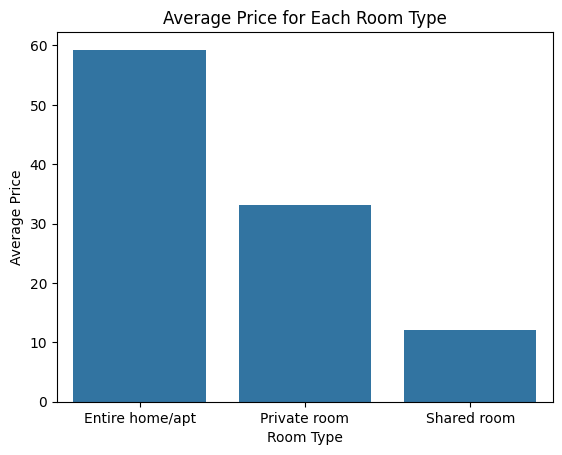

In [99]:
# ####################################################################### #
# Question 1.8

# Find all unique room types
room_types = df['room_type'].unique()

# Initialize an empty dictionary to store the average price for each room type
avg_prices = {}

# Loop over the unique room types
for room_type in room_types:
    # Filter the DataFrame to only include rows with the current room type
    room_type_df = df[df['room_type'] == room_type]

    # Calculate the average price for the current room type and store it in the dictionary
    avg_prices[room_type] = room_type_df['price'].mean()

# Convert the dictionary to a DataFrame
avg_prices_df = pd.DataFrame(list(avg_prices.items()), columns=['Room Type', 'Average Price'])

# Use seaborn's barplot function to create the histogram
sns.barplot(data=avg_prices_df, x='Room Type', y='Average Price')

# Set the labels and title for the graph
plt.xlabel('Room Type')
plt.ylabel('Average Price')
plt.title('Average Price for Each Room Type')

# Save the plot to a file
plt.savefig('question_1_8.png')

# ####################################################################### #

Ερώτημα 1.9

(το αποτέλεσμα εμφανίζεται ανοίγοντας το αρχείο question_1_9.html)

In [100]:
# ####################################################################### #
# Question 1.9

# Load the data
df1 = pd.read_csv('output.csv')

# Filter rows where 'month' is 'march'
df = df1[df1['month'] == 'march'].head(5000)

# Create a new map centered around the average latitude and longitude values
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=13)

# Add a marker for each property
for idx, row in df.iterrows():
    # Create a popup with the desired information
    popup_text = f"Bed Type: {row['bed_type']}, Room Type: {row['room_type']}, Transit: {row['transit']}"
    popup = folium.Popup(popup_text, max_width=300)

    # Create and add the marker to the map
    marker = folium.Marker(location=[row['latitude'], row['longitude']], popup=popup)
    marker.add_to(m)

# Save the map
m.save('question_1_9.html')

# ####################################################################### #

Ερώτημα 1.10

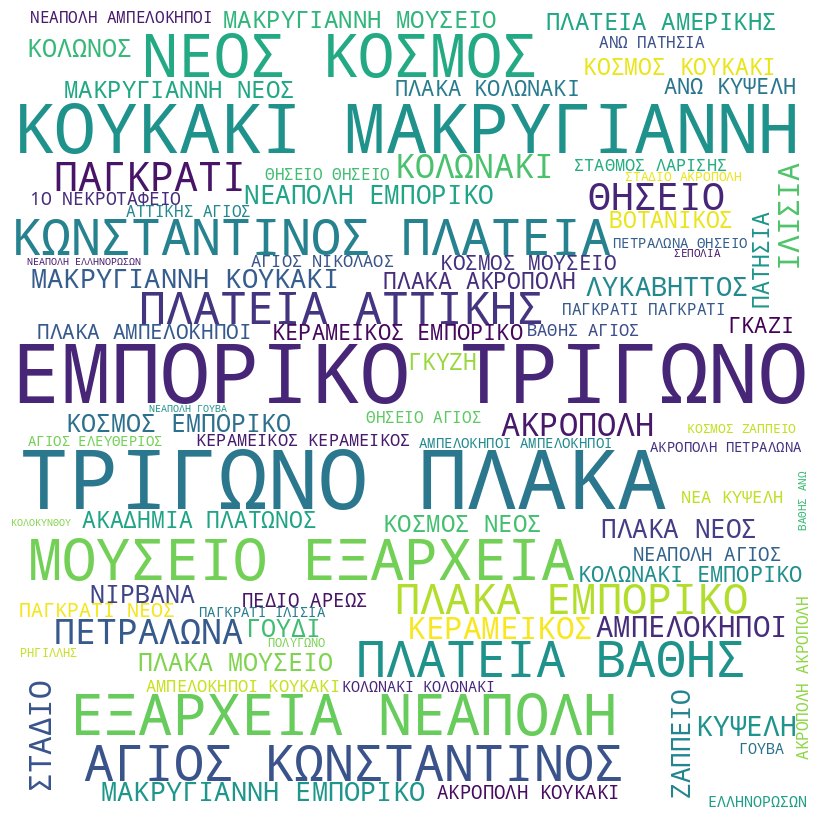

<Figure size 640x480 with 0 Axes>

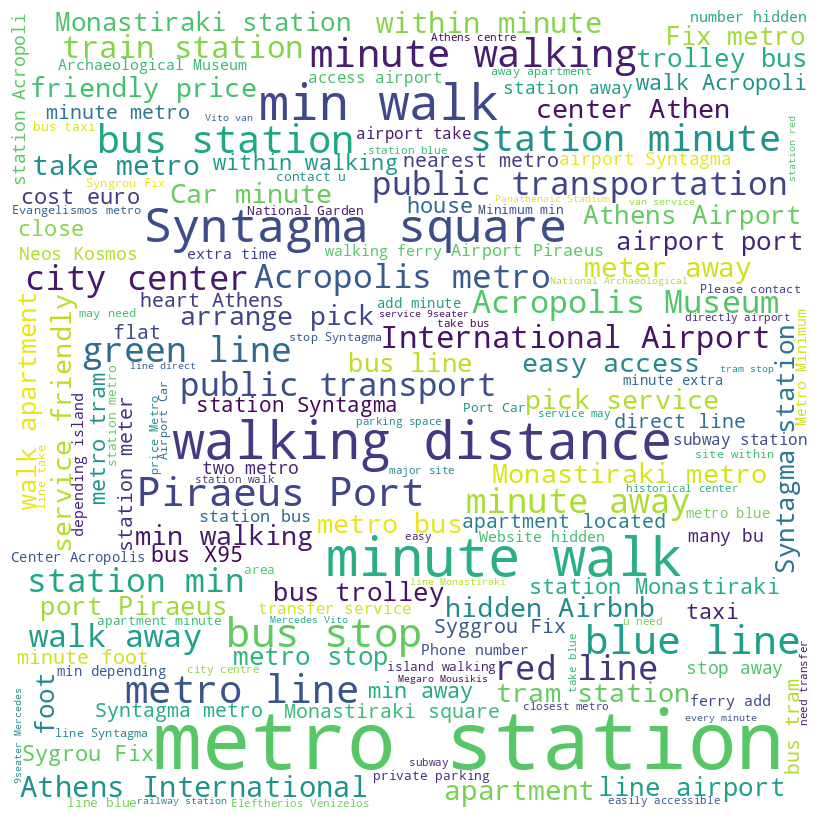

<Figure size 640x480 with 0 Axes>

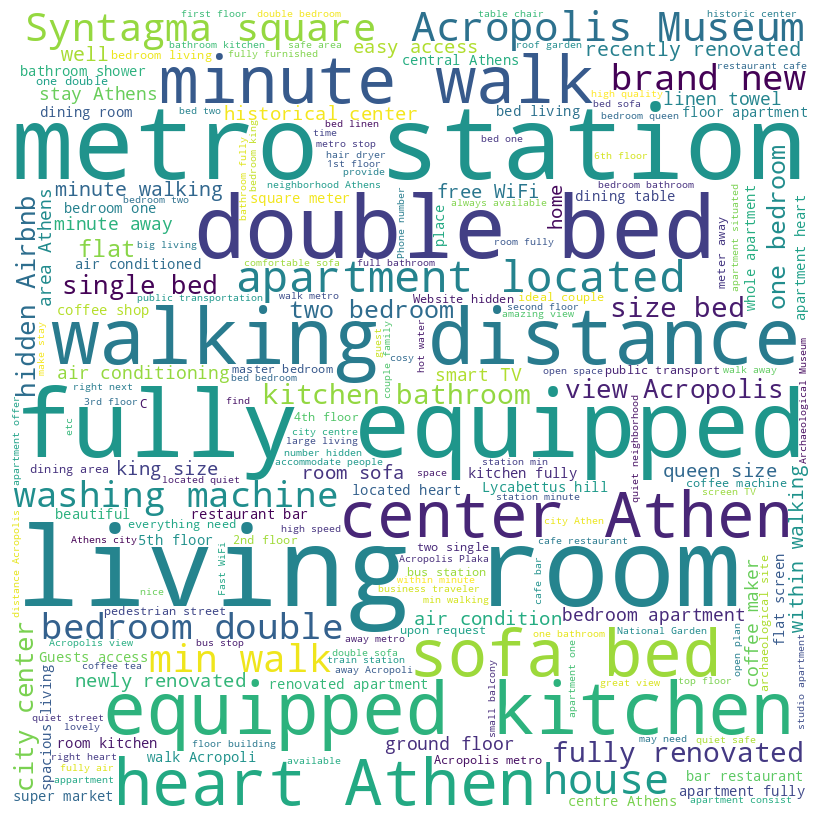

<Figure size 640x480 with 0 Axes>

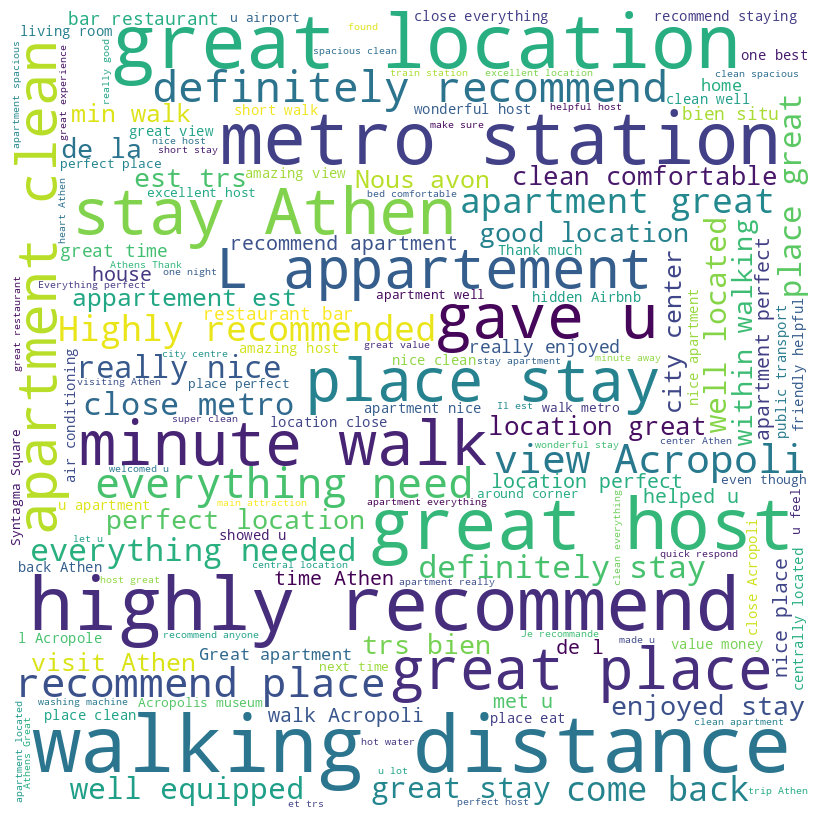

In [101]:
# ####################################################################### #
# Question 1.10

# Read the CSV file
df = pd.read_csv('output.csv')

# Convert the 'neighbourhood' column to a single string
text = ' '.join(df['neighbourhood'])

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(text)

# Plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

# Save the plot to a file
plt.savefig('question_1_10a.png');

# Create a new wordcloud
plt.figure()

# Convert the 'transit' column to string and then to a single string
text = ' '.join(df['transit'].astype(str))

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(text)

# Plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

# Save the plot to a file
plt.savefig('question_1_10b.png');

# Create a new wordcloud
plt.figure()

# Convert the 'description' column to string and then to a single string
text = ' '.join(df['description'].astype(str))

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(text)

# Plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

# Save the plot to a file
plt.savefig('question_1_10c.png');

# Create a new wordcloud
plt.figure()

# Read the CSV file
df = pd.read_csv('reviews_output.csv')

# Convert the 'comments' column to string type and then to a single string
text = ' '.join(df['comments'].astype(str))

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(text)

# Plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

# Save the plot to a file
plt.savefig('question_1_10d.png');

# ####################################################################### #

Ερώτημα 1.11

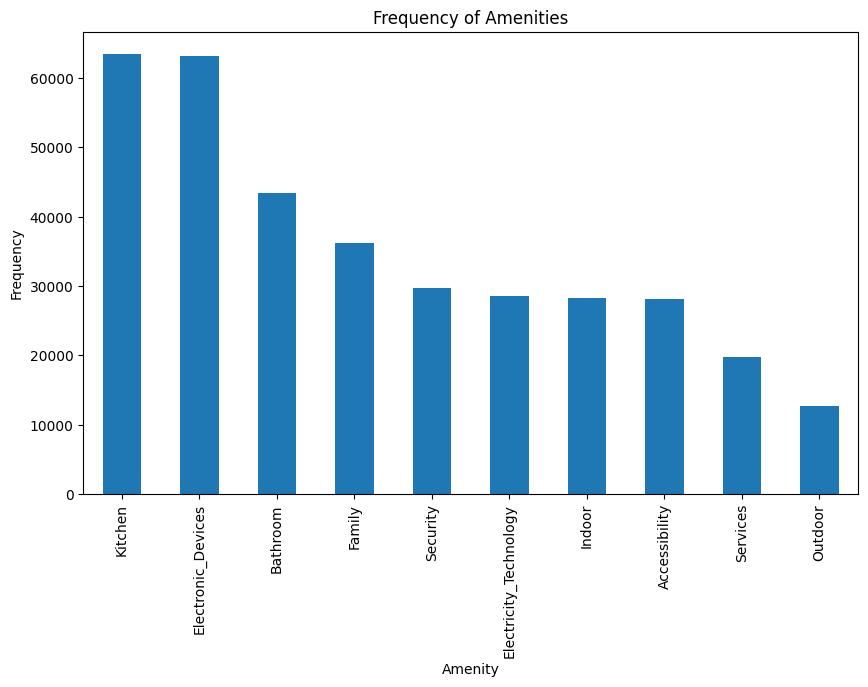

In [108]:
# ####################################################################### #
# Question 1.11

# Read the data from the CSV file
df = pd.read_csv('output.csv')

# Split the words in each row of the 'amenities' column
df['amenities'] = df['amenities'].str.split()

# Count the frequency of each word
word_counts = df['amenities'].explode().value_counts()

# Plot the word counts
plt.figure(figsize=(10, 6))
word_counts.plot(kind='bar')
plt.title('Frequency of Amenities')
plt.xlabel('Amenity')
plt.ylabel('Frequency')

# Save the plot to a file
plt.savefig('question_1_11.png')

# ####################################################################### #

Ερώτημα 1.12

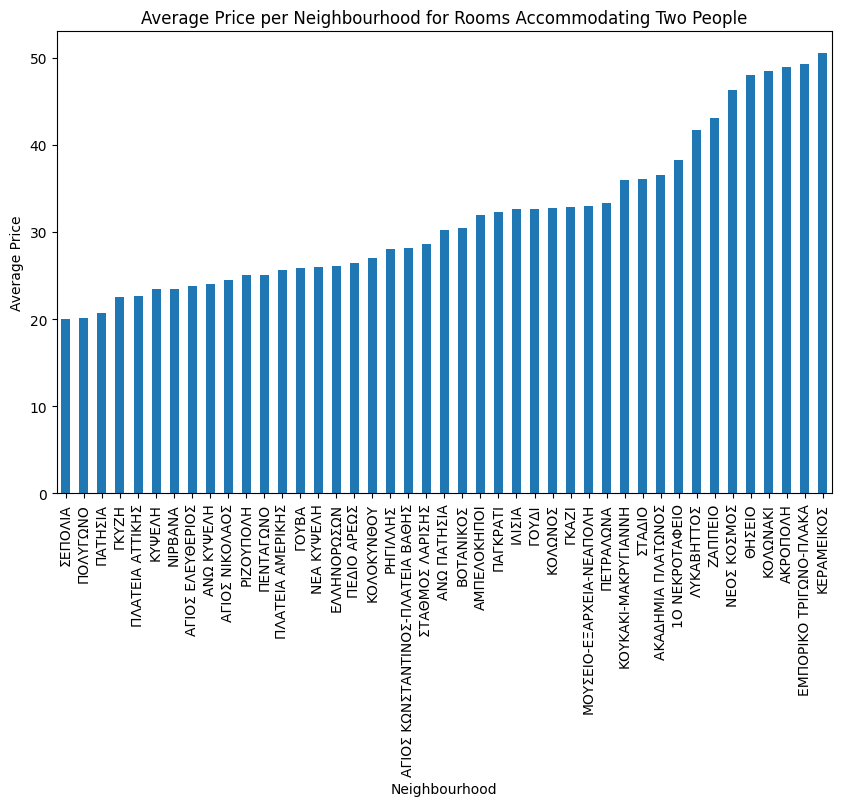

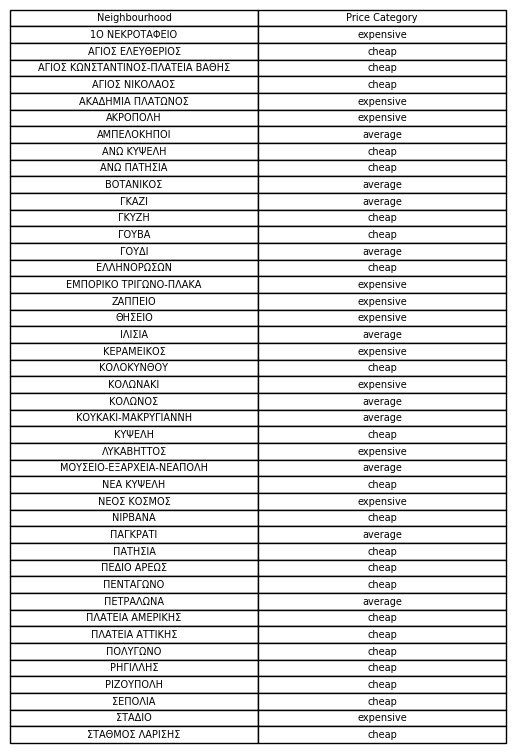

In [41]:
# ####################################################################### #
# Question 1.12

# Read the data from the CSV file
df = pd.read_csv('output.csv')

# Remove the dollar sign and commas from the price column and convert it to float
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

# Filter the DataFrame to only include listings that accommodate two people
df_two_people = df[df['accommodates'] == 2]

# Group by neighbourhood and calculate the mean price
mean_price_per_neighbourhood = df_two_people.groupby('neighbourhood')['price'].mean()

# Sort by mean price
sorted_neighbourhoods = mean_price_per_neighbourhood.sort_values()

# Plot the results
plt.figure(figsize=(10, 6))
sorted_neighbourhoods.plot(kind='bar')
plt.title('Average Price per Neighbourhood for Rooms Accommodating Two People')
plt.xlabel('Neighbourhood')
plt.ylabel('Average Price')

# Save the plot to a file
plt.savefig('question_1_12_plot.png')

# Define the bin edges based on the min, median and max values
bins = [np.min(mean_price_per_neighbourhood),
        np.percentile(mean_price_per_neighbourhood, 50),
        np.percentile(mean_price_per_neighbourhood, 75),
        np.max(mean_price_per_neighbourhood)]

# Define the labels for the bins
labels = ['cheap', 'average', 'expensive']

# Create a new column 'price_category' by cutting the mean price into bins
mean_price_per_neighbourhood = pd.cut(mean_price_per_neighbourhood, bins=bins, labels=labels, include_lowest=True)

# Get data
neighbourhoods = mean_price_per_neighbourhood.index.tolist()
price_categories = mean_price_per_neighbourhood.tolist()

# Create figure
fig, ax = plt.subplots(1, 1)

# Hide axes
ax.axis('tight')
ax.axis('off')

# Create table and display it
table_data = list(zip(neighbourhoods, price_categories))
ax.table(cellText=table_data, colLabels=['Neighbourhood', 'Price Category'], cellLoc = 'center', loc='center')

# Save the plot to a file
plt.savefig('question_1_12_table.png')

# ####################################################################### #

Ερώτημα 1.13

(α) Για κάθε zipcode πόσα ξεχωριστά διαμερίσματα υπάρχουν το συγκεκριμένο έτος.

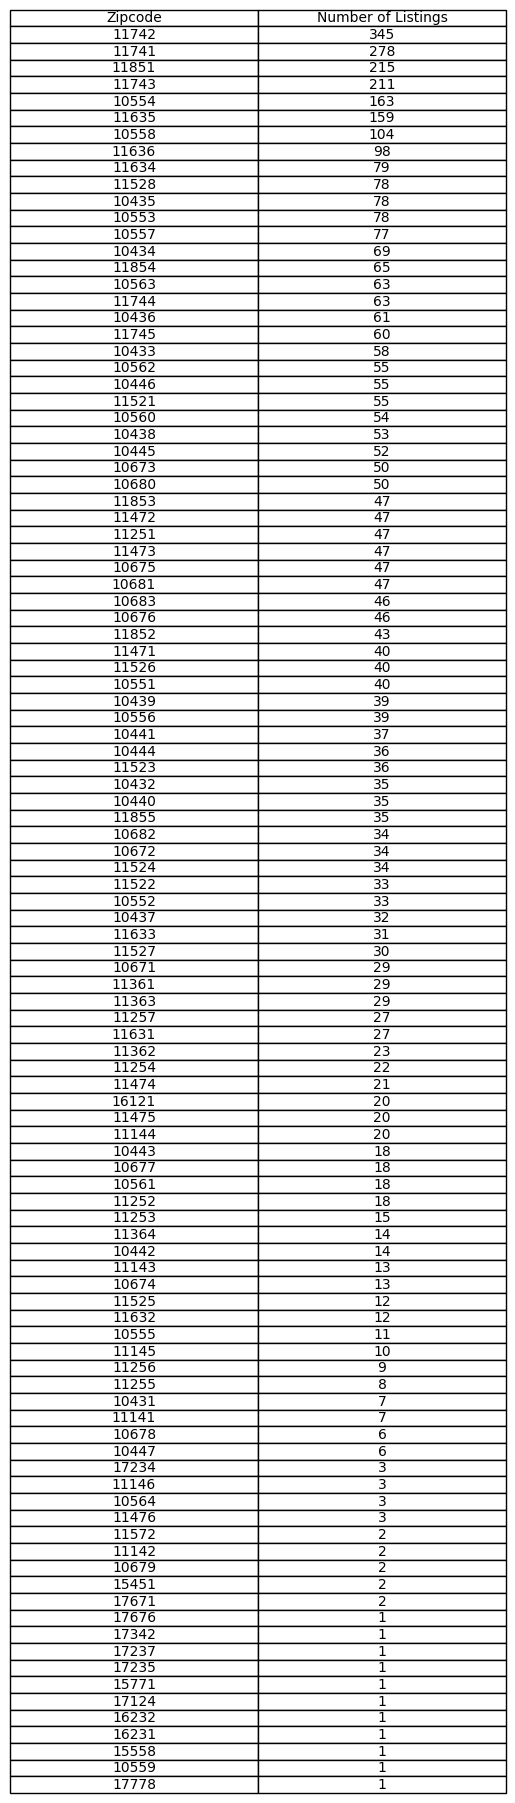

In [42]:
# ####################################################################### #
# Question 1.13

# (a) ___________________________________________________________________ #

# Read the data from the CSV file
df = pd.read_csv('output.csv')

# Group by 'zipcode' and count the number of unique 'id's
zipcode_counts = df.groupby('zipcode')['id'].nunique()

# Sort the counts in descending order
sorted_zipcodes = zipcode_counts.sort_values(ascending=False)

# Get data
zipcodes = sorted_zipcodes.index.tolist()
number_of_listings = sorted_zipcodes.tolist()

# Create figure
fig, ax = plt.subplots(1, 1)

# Hide axes
ax.axis('tight')
ax.axis('off')

# Create table and display it
table_data = list(zip(zipcodes, number_of_listings))
ax.table(cellText=table_data, colLabels=['Zipcode', 'Number of Listings'], cellLoc = 'center', loc='center')

# Save the plot to a file
plt.savefig('question_1_13_a.png')

# ####################################################################### #

Ερώτημα 1.13

(β) Μέσος όρος βαθμολογιών αν περιοχή κάθε μήνα.

<ipython-input-43-16333820ddd6>:7: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feb = pd.read_csv(listings_path_febrouary)
<ipython-input-43-16333820ddd6>:8: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mar = pd.read_csv(listings_path_march)
<ipython-input-43-16333820ddd6>:9: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_apr = pd.read_csv(listings_path_april)


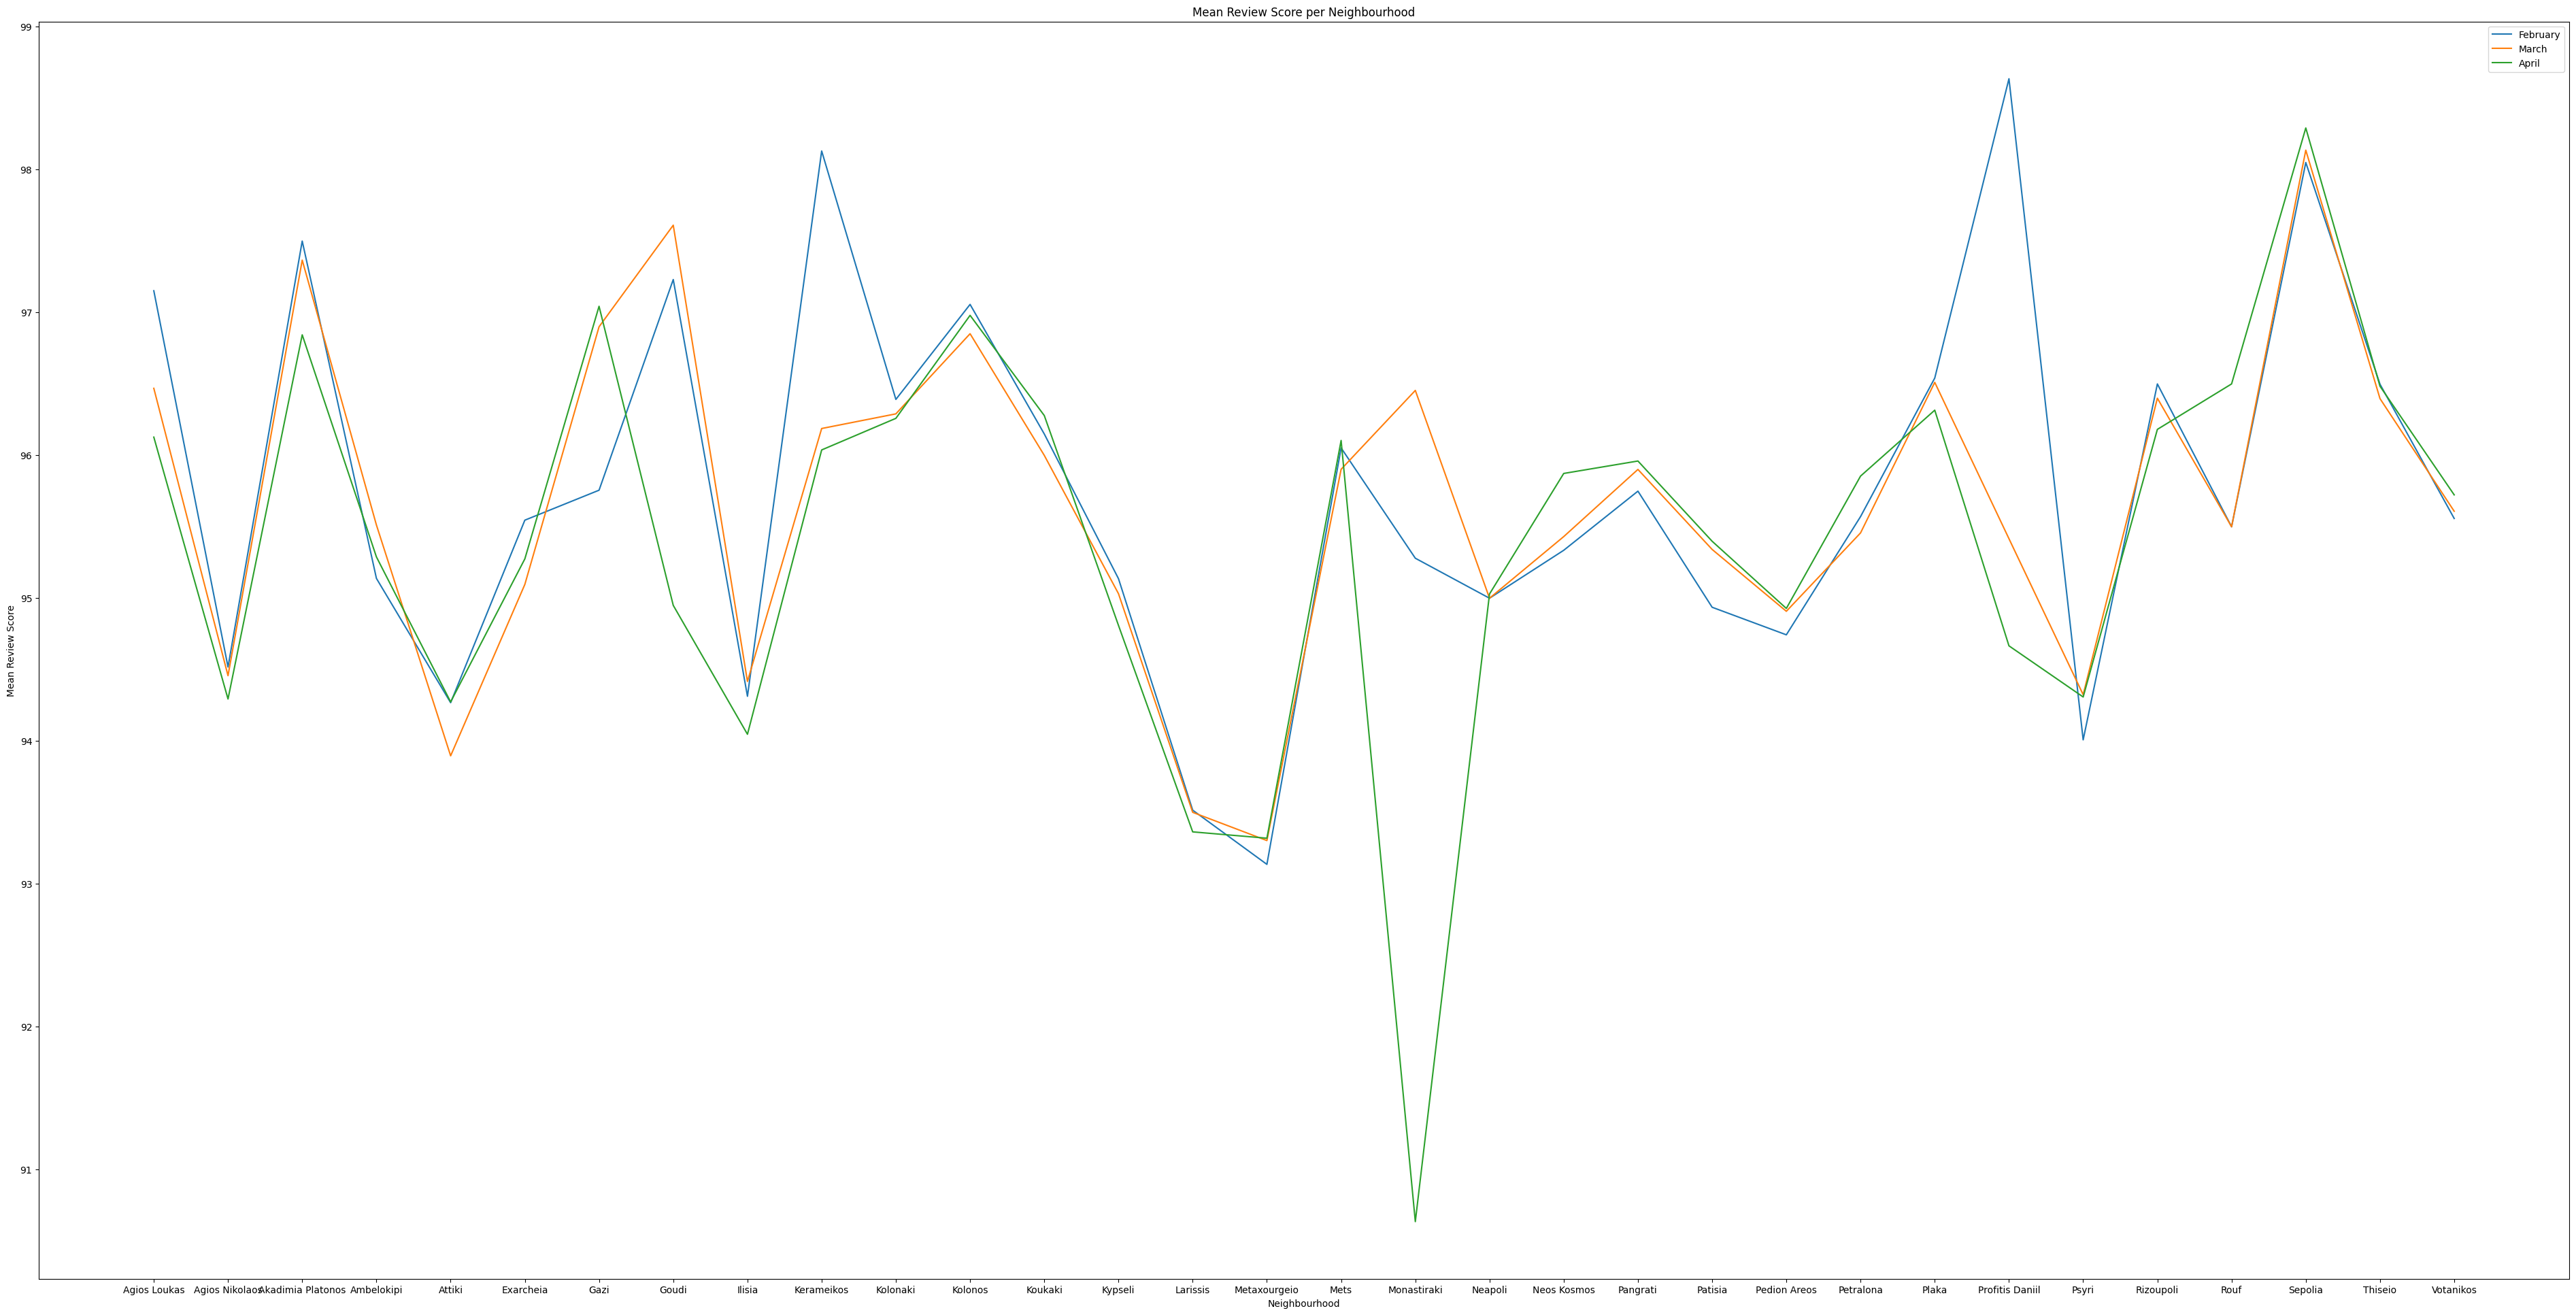

In [43]:
# ####################################################################### #
# Question 1.13

# (b) ___________________________________________________________________ #

# Load the data
df_feb = pd.read_csv(listings_path_febrouary)
df_mar = pd.read_csv(listings_path_march)
df_apr = pd.read_csv(listings_path_april)

# Calculate mean review score per neighbourhood for each month
mean_scores_feb = df_feb.groupby('neighbourhood')['review_scores_rating'].mean()
mean_scores_mar = df_mar.groupby('neighbourhood')['review_scores_rating'].mean()
mean_scores_apr = df_apr.groupby('neighbourhood')['review_scores_rating'].mean()

# Plot the results
plt.figure(figsize=(48, 24))  # Increase the x-dimension of the figure size
plt.plot(mean_scores_feb, label='February')
plt.plot(mean_scores_mar, label='March')
plt.plot(mean_scores_apr, label='April')
plt.title('Mean Review Score per Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Mean Review Score')
plt.legend()
plt.show()
# ####################################################################### #

Ερώτημα 1.13

(γ) Μέσος όρος τιμής άνα είδος κατοικίας.

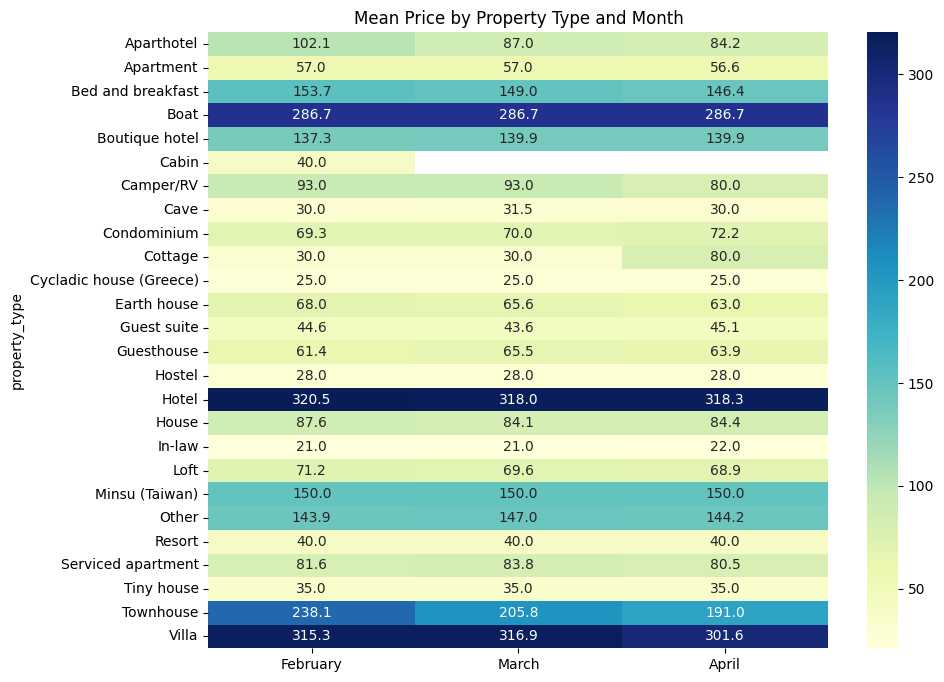

In [44]:
# ####################################################################### #
# Question 1.13

# (c) ___________________________________________________________________ #

# Define a function to clean the price column
def clean_price(price):
    if isinstance(price, str):
        price = price.replace('$', '')
        price = price.replace(',', '')  # Add this line to remove commas
        price = float(price)
    return round(price, 1)

# Apply the function to the price column of each DataFrame
df_feb['price'] = df_feb['price'].apply(clean_price)
df_mar['price'] = df_mar['price'].apply(clean_price)
df_apr['price'] = df_apr['price'].apply(clean_price)

# Group each DataFrame by property type and calculate the mean price
mean_price_feb = df_feb.groupby('property_type')['price'].mean()
mean_price_mar = df_mar.groupby('property_type')['price'].mean()
mean_price_apr = df_apr.groupby('property_type')['price'].mean()

# Merge the resulting DataFrames on the property type column
df = pd.concat([mean_price_feb, mean_price_mar, mean_price_apr], axis=1)
df.columns = ['February', 'March', 'April']

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, fmt=".1f", cmap='YlGnBu')
plt.title('Mean Price by Property Type and Month')
plt.show()

# ####################################################################### #

Ερώτημα 1.14

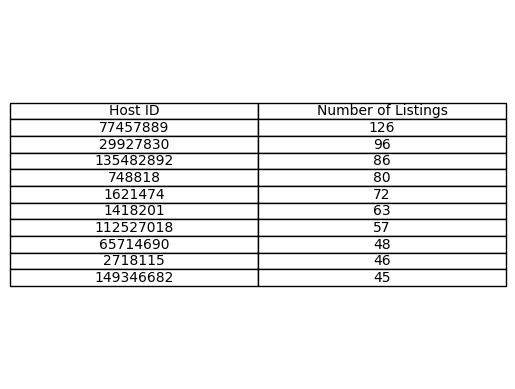

In [45]:
# ####################################################################### #
# Question 1.14

# Group by 'host_id' and count the number of unique 'id's
host_counts = listings0_df.groupby('host_id')['id'].nunique()

# Sort the counts in descending order
sorted_hosts = host_counts.sort_values(ascending=False)

# Select the first 10 hosts
top_hosts = sorted_hosts.head(10)

# Get data
host_ids = top_hosts.index.tolist()
number_of_listings = top_hosts.tolist()

# Create figure
fig, ax = plt.subplots(1, 1)

# Hide axes
ax.axis('tight')
ax.axis('off')

# Create table and display it
table_data = list(zip(host_ids, number_of_listings))
ax.table(cellText=table_data, colLabels=['Host ID', 'Number of Listings'], cellLoc = 'center', loc='center')

# Save the plot to a file
plt.savefig('question_1_14.png')

# ####################################################################### #

Ερώτημα 1.15

Παρατηρούμε τις εξής διαφορές/ομοιόιτητες μεταξύ των δύο ετών.

*  Όσον αφορά την πορεία των τιμών μεταξύ των δύο ετών, πρόκυπτει ότι την χρονιά 2023 ο μέσος όρος των τιμών είχε ανοδική πορεία και σε ορισμένες περιπτώσεις σχεδόν διπλασιάστηκε σε σχέση με το 2019. Επίσης η πορεία των τιμών μεταξύ των μηνών Φεβρουάριος, Μάρτιος, Απρίλιος το 2019 είναι σχεδόν σταθερή, ενώ η πορεία των τιμών μεταξύ των μηνών Μάρτιος, Ιούνιος, Σεπτέμβριος το 2023 είναι ανοδική τους πρώτους δύο απο αυτούς τους μήνες και στη συνέχεια φαίνεται να σταθεροποιείται ο μέσος όρος των τιμών τον τελευταίο μήνα.

* Όσον αφορά των αριθμό των καταχωρήσεων μεταξύ των δύο ετών, παρατηρούμε ότι και τις δύο χρονιές οι πρώτες δέκα σε αριθμό καταχωρήσεων περιοχές παραμένουν ίδιες , ωστόσο την χρονιά 2023 οι καταχωρήσεις είναι περισσότερες σε κάθε μία απο αυτές.

* Μεταξύ των δύο ετών υπάρχουν διαφοροποιήσεις στο μέσο όρο των τιμών για κάθε είδος δωματίου. Συγκεκριμένα το 2019 ο πιο ακριβός τύπος δωματίου ήταν το Entire home/apt, ακολουθούμενο απο το Private room και απο το Shared room. Aπο την άλλη ο πιο ακριβός τύπος δωματίου το 2023 ήταν το Hotel room, έπειτα ακολουθούσαν το Private room, Entire home/apt και Shared room. Ορισμένες διαφορές μεταξύ των πιο ακριβών δωματίων το Entire home/apt αυξήθηκε κατά 40€ το 2023 σε σχέση με το 2019, ομοίως το Private room αυξήθηκε κατά 90€ το 2023 σε σχέση με το 2019 και ξεπέρασε το Entire home/apt σε μέσο όρο τιμής, όπως επίσης και το Shared room αυξήθηκε κατά 20€ το 2023 σε σχέση με το 2019. Επιπλέον το 2023 εμφανίστηκε ένας νέος τύπος δωματίου το Hotel room, το οποίο έτεινε να αγγίζει τα 200€.
  
* Μεταξύ των δύο ετών προκύπτουν διαφορές όσον αφορά ορισμένες γειτονιές, καθώς άλλαξε η αγοραστική τους αξία και αυτό φαίνεται στον παρακάτω πίνακα. Συγκερκιμένα οι παρακάτω περιοχές χαρακτηρίστηκαν ως ακριβότερες ή φθηνότερες. Επίσης το 2023 δεν υπήρχε καταχώρηση στην περιοχή ΠΕΝΤΑΓΩΝΟ, ενώ υπήρχε η περιοχή ΠΡΟΜΠΟΝΑΣ η οποία την χρονιά 2019 δεν είχε κάποια καταχώρηση. Οι υπόλοιπες περιοχές παρέμειναν ίδιες όσον αφορά την αξία τους. Αξίζει να σημειωθεί ότι η περιοχή του Ζαππείου ο μέσος όρος τιμής απο 45€ αυξήθηκε στα 200€, ενώ γενικά υπήρχε μια ανοδική πορεία με κάποιες τιμές να έχουν διπλασιαστεί.

\begin{array}{|c|c|} \hline
   & 2019 & \rightarrow & 2023 \\ \hline
  1ο\ ΝΕΚΡΟΤΑΦΕΙΟ & expensive & \rightarrow & average \\ \hline
  ΑΓΙΟΣ\ ΕΛΕΥΘΕΡΙΟΣ & cheap & \rightarrow & expensive \\\hline
  ΑΓΙΟΣ\ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ\ ΒΑΘΗΣ & cheap & \rightarrow & average \\ \hline
  ΑΚΑΔΗΜΙΑ\ ΠΛΑΤΩΝΟΣ & expensive & \rightarrow & cheap \\ \hline
  ΒΟΤΑΝΙΚΟΣ & average & \rightarrow & cheap \\ \hline
  ΓΟΥΔΙ & average & \rightarrow &cheap \\ \hline
  ΕΛΛΗΝΟΡΩΣΩΝ & cheap & \rightarrow & expensive \\ \hline
  ΚΟΛΩΝΟΣ & average & \rightarrow & cheap \\ \hline
  ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ & average & \rightarrow & expensive \\ \hline
  ΝΕΟΣ\ ΚΟΣΜΟΣ & expensive & \rightarrow & average \\ \hline
  ΠΑΓΚΡΑΤΙ & average & \rightarrow & expensive \\ \hline
  ΡΗΓΙΛΛΗΣ & cheap & \rightarrow & average \\ \hline
  ΣΤΑΔΙΟ & expensive & \rightarrow & average \\ \hline
\end{array}



# Ερώτημα 2o: Recommendation System

In [118]:
def get_top_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def recommend(item_id, num):
    # Load the similar IDs dictionary from the JSON file
    with open('similar_ids_dict.json', 'r') as f:
        similar_ids_dict = json.load(f)

    # Load the similar scores dictionary from the JSON file
    with open('similar_scores_dict.json', 'r') as f:
        similar_scores_dict = json.load(f)

    # Convert the item_id to str (since the keys in the dictionary are strings)
    item_id = str(item_id)

    # Check if the item_id exists in the dictionaries
    if item_id not in similar_ids_dict or item_id not in similar_scores_dict:
        return f"Item ID {item_id} not found in the dictionaries."

    # Get the list of similar IDs and scores for the given item_id
    similar_ids = similar_ids_dict[item_id]
    similar_scores = similar_scores_dict[item_id]

    # Check if the number of similar IDs is less than the requested number
    if len(similar_ids) < num:
        return f"Only {len(similar_ids)} similar items found for item ID {item_id}."

    # Get the top num similar IDs and scores
    top_similar_ids = similar_ids[:num]
    top_similar_scores = similar_scores[:num]

    # Print the recommended items
    print(f"Recommending {num} listings similar to item ID {item_id}")
    print("---------------------------------------------------------")
    for id, score in zip(top_similar_ids, top_similar_scores):
        # Assuming df is the DataFrame that contains the item details
        item = df[df['id'] == int(id)]
        print(f"Recommended: {item['name'].values[0]}")
        print(f"Description: {item['description'].values[0]}")
        print(f"Score: {score}")
        print("......")

In [119]:
new_df = df.copy()
new_df['description_name'] = df['description'] + " " + df['name']
new_df['description_name'] = new_df['description_name'].str.replace(' etc', '')


new_df.to_csv('new_df.csv', index=False)

# Step 1: Read the CSV file into a DataFrame
new_df = pd.read_csv('new_df.csv')

# Keep only the first 7000 lines
new_df = new_df.iloc[:4000]

# Text cleaning
new_df = text_cleaning(new_df)

# Step 2: Extract the 'description_name' column and convert it into a TF-IDF matrix
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
tfidf_matrix = vectorizer.fit_transform(new_df['description_name'])

# Step 3: Calculate the cosine similarity matrix for the TF-IDF matrix
cosine_sim_matrix = cosine_similarity(tfidf_matrix)

# Step 4: For each row in the cosine similarity matrix, find the indices of the top 300 most similar items
top_300_similar_indices = np.argsort(cosine_sim_matrix, axis=1)[:, -301:-1]  # We use -301:-1 to exclude the self index

# Step 5: Create a dictionary where the keys are the IDs and the values are lists of the 100 most similar IDs
similar_ids_dict = {new_df.iloc[i]['id']: list(set([id for id in new_df.iloc[top_300_similar_indices[i]]['id'] if id != new_df.iloc[i]['id']]))[:100] for i in range(new_df.shape[0])}

# Create a dictionary where the keys are the IDs and the values are lists of the 100 most similar scores
similar_scores_dict = {new_df.iloc[i]['id']: list(set([cosine_sim_matrix[i][j] for j in top_300_similar_indices[i] if new_df.iloc[j]['id'] != new_df.iloc[i]['id']]))[:100] for i in range(new_df.shape[0])}
similar_scores_dict = {str(k): v for k, v in similar_scores_dict.items()}


# Convert the keys to str
similar_ids_dict = {str(k): v for k, v in similar_ids_dict.items()}

# Now write the dictionary to a JSON file
with open('similar_ids_dict.json', 'w') as f:
    json.dump(similar_ids_dict, f)

with open('similar_scores_dict.json', 'w') as f:
    json.dump(similar_scores_dict, f)



In [120]:
# Assuming similarity_matrix is defined
recommend(10595, 5)

# Read the CSV file
new_df = pd.read_csv('new_df.csv')

# Extract the 'description_name' column
corpus = new_df['description_name'].tolist()

# Tokenize the text
tokens = [word_tokenize(text) for text in corpus]

# Flatten the list of tokens
tokens = [token for sublist in tokens for token in sublist]

# Find bigrams
bigram_finder = BigramCollocationFinder.from_words(tokens)

# Get the 10 most common bigrams
bigrams = bigram_finder.nbest(BigramAssocMeasures.raw_freq, 10)

for bigram in bigrams:
    print(bigram)

Recommending 5 listings similar to item ID 10595
---------------------------------------------------------
Recommended: neoclassical luxurius apartment ap 3 keramikos
Description: live style brand new luxurius apartment center athens apartment located keramikos heart athens nly 5 10 minute walk acropolis psirri gkazi monastiraki 5 minute walk subway metro station omonoia metaxourgeio fastest transport city 2 5 minute walk apartment find plenty restaurant bar mini market bank shop everything need step away ap 3 luxurius third floor apartment accommodate 6 adult apartment feature specious living room double sofa bed accommodate 2 extra quest fully equipped kitchen double bed bedroom 2 single bed bedroom one bathroom one bed available upon request case needed living room equipped satellite tv apartment kitchen fully equipped including refrigerator deep freezer oven microwave oven coffee mach
Score: 0.048921573008779085
......
Recommended: cosy apartment heart athens
Description: welcome l